<a href="https://colab.research.google.com/github/lnsayer/lnsayer.github.io/blob/main/amazon_node_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Dataset (from PyTorch Geometric) Node Classification Project

The Amazon Computers and Amazon Photo networks from the “Pitfalls of Graph Neural Network Evaluation” paper. Nodes represent goods and edges represent that two goods are frequently bought together. Given product reviews as bag-of-words node features, the task is to map goods to their respective product category.

In [ ]:
!pip install torch_geometric
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 10.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinu

In [ ]:
from torch_geometric.datasets import Amazon
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAUROC


In [ ]:
dataset = Amazon(root="data/Amazon", name="Computers")

data = dataset[0]

print(f"Number of nodes in graph is: {data.x.shape[0]}")
print(f"Number of features for each node is {dataset.num_features}")
print(f"Number of edges is {data.edge_index.shape[1]}")
print(f"We want to predict the classes of the 13752 Computers\n")
print(data, "\n")

print(f"The number of class members for each class: {dataset.num_classes}\n")
print(f"Class labels: \n{data.y.unique(return_counts=True)}")
#dir(dataset)

Processing...


Number of nodes in graph is: 13752
Number of features for each node is 767
Number of edges is 491722
We want to predict the classes of the 13752 Computers

Data(x=[13752, 767], edge_index=[2, 491722], y=[13752]) 

The number of class members for each class: 10

Class labels: 
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 436, 2142, 1414,  542, 5158,  308,  487,  818, 2156,  291]))


Done!


In [ ]:
# # We will split the data using a transductive method in which the whole input graph is put through the forward method however
# we split the labels (classes) for the loss function. We will use a split of train: 80%, val: 10% and test: 10%.
torch.manual_seed(42)
# indices of the nodes randomly shuffled
indices = torch.randperm(data.x.shape[0])
print(f"Shuffled indices are {indices} of length {len(indices)}\n")

# train:80%, val:10% and test:10%
train_indices = indices[:int(0.8*len(indices))]
val_indices = indices[int(0.8*len(indices)):int(0.9*len(indices))]
test_indices = indices[int(0.9*len(indices)):]
print(f"Train shuffled indices are {train_indices} of length {len(train_indices)}\n")
print(f"Test shuffled indices are {test_indices} of length {len(test_indices)}\n")
print(f"Validation shuffled indices are {val_indices} of length {len(val_indices)}\n")

# train labels to pass
train_labels = data.y[train_indices]
val_labels = data.y[val_indices]
test_labels = data.y[test_indices]


Shuffled indices are tensor([11094,  1027,  4378,  ...,  8275,  9941,  4338]) of length 13752

Train shuffled indices are tensor([11094,  1027,  4378,  ...,  8049, 12835,    92]) of length 11001

Test shuffled indices are tensor([8461, 5630, 8059,  ..., 8275, 9941, 4338]) of length 1376

Validation shuffled indices are tensor([  794,  4772,  8150,  ..., 12435,   687,  5437]) of length 1375



In [ ]:
data.is_undirected()

True

In [ ]:
# Create a model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

nb_hidden_channels = 32

class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = GCNConv(in_channels = dataset.num_features,
                         out_channels = nb_hidden_channels)
    self.conv2 = GCNConv(in_channels = nb_hidden_channels,
                         out_channels = dataset.num_classes)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    #x = F.dropout(x, training=self.training)
    # could try log softmax: improved numerical performance and gradient optimisation
    x = F.log_softmax(x, dim=1)

    return x

# defined it later too
gcn_model = GCN()
gcn_model


GCN(
  (conv1): GCNConv(767, 32)
  (conv2): GCNConv(32, 10)
)

In [ ]:
# Run training
torch.manual_seed(42)

# set device as GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# instantiate the gcn_model
gcn_model = GCN()
# move the model to the gpu (or cpu is not available)
gcn_model = gcn_model.to(device)

optimiser = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
loss_fn = torch.nn.NLLLoss()

# define the data
data = dataset[0]
data = data.to(device)

nb_epochs = 1001

epochs = np.arange(0, 1001)
train_loss_array = np.zeros(1001)
train_acc_array = np.zeros(1001)
test_loss_array = np.zeros(1001)
test_acc_array = np.zeros(1001)



for epoch in range(nb_epochs):
  # Train
  # forward pass on the network
  gcn_model.train()
  out = gcn_model(data)

  # calculate the loss
  loss = loss_fn(out[train_indices], data.y[train_indices])

  # calculate the label probabilities
  label_probs = out[train_indices]
  # calculate the label predictions
  label_preds = torch.argmax(label_probs, dim=1)
  # calculate accuracy
  accuracy = (label_preds == data.y[train_indices]).sum()/len(label_preds)

  train_loss_array[epoch] = loss
  train_acc_array[epoch] = accuracy

  # zero the gradients
  optimiser.zero_grad()
  # backpropagate the loss
  loss.backward()
  # update the optimizer
  optimiser.step()

  # Test
  # Put the model in eval mode
  gcn_model.eval()
  with torch.inference_mode():
    # Calculate the loss for the test set
    test_loss = loss_fn(out[test_indices], data.y[test_indices])

    # Calculate the predictions for the test set and then calculate the accuracy
    test_label_probs = out[test_indices]
    test_label_preds = torch.argmax(test_label_probs, dim=1)
    test_accuracy = (test_label_preds == data.y[test_indices]).sum()/len(test_label_preds)

    test_loss_array[epoch] = test_loss
    test_acc_array[epoch] = test_accuracy


  if epoch % 10 == 0:
    print(f"Epoch: {epoch}, Train Loss: {loss:.4f}, Train Accuracy: {accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch: 0, Train Loss: 2.4572, Train Accuracy: 0.1576, Test Loss: 2.4824, Test Accuracy: 0.1468
Epoch: 10, Train Loss: 1.9014, Train Accuracy: 0.4634, Test Loss: 1.9303, Test Accuracy: 0.4455
Epoch: 20, Train Loss: 1.4656, Train Accuracy: 0.6603, Test Loss: 1.5017, Test Accuracy: 0.6257
Epoch: 30, Train Loss: 1.2304, Train Accuracy: 0.6843, Test Loss: 1.2750, Test Accuracy: 0.6533
Epoch: 40, Train Loss: 1.0095, Train Accuracy: 0.7311, Test Loss: 1.0531, Test Accuracy: 0.6999
Epoch: 50, Train Loss: 0.8497, Train Accuracy: 0.7476, Test Loss: 0.8849, Test Accuracy: 0.7246
Epoch: 60, Train Loss: 0.7312, Train Accuracy: 0.7957, Test Loss: 0.7653, Test Accuracy: 0.7718
Epoch: 70, Train Loss: 0.6261, Train Accuracy: 0.8279, Test Loss: 0.6593, Test Accuracy: 0.8060
Epoch: 80, Train Loss: 0.5473, Train Accuracy: 0.8497, Test Loss: 0.5782, Test Accuracy: 0.8256
Epoch: 90, Train Loss: 0.4906, Train Accuracy: 0.8649, Test Loss: 0.5264, Test Accuracy: 0.8445
Epoch: 100, Train Loss: 0.4496, Train Acc

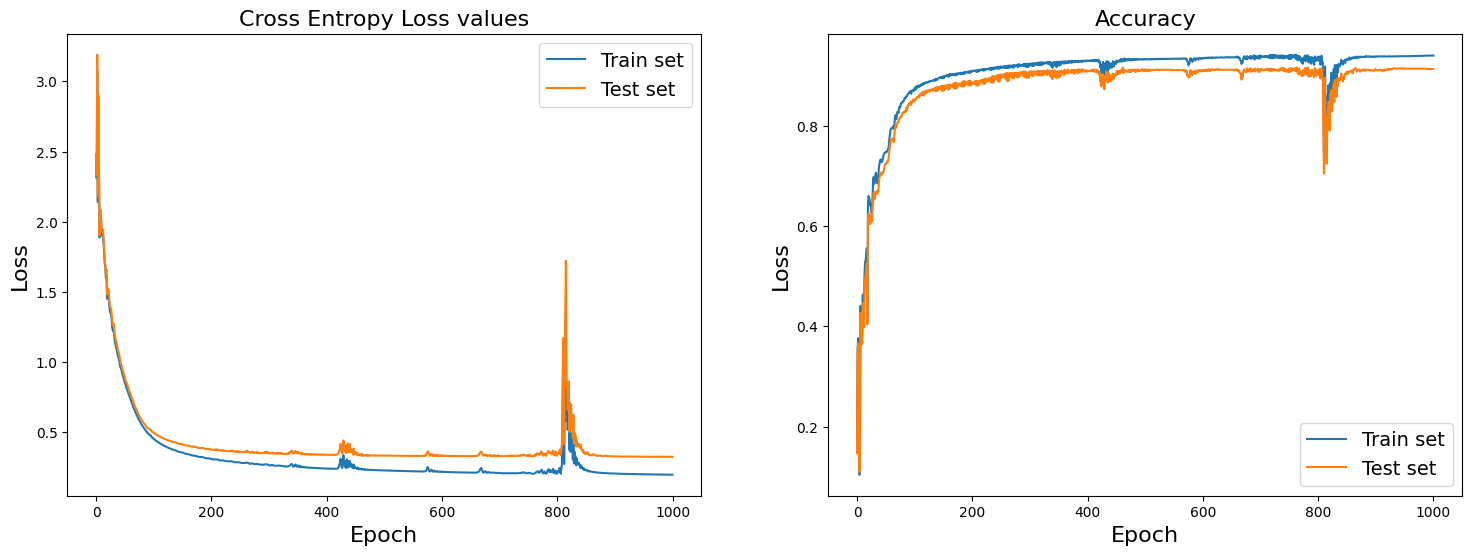

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

ax0.plot(epochs, train_loss_array, label = "Train set")
ax0.plot(epochs, test_loss_array, label = "Test set")

ax1.plot(epochs, train_acc_array, label="Train set")
ax1.plot(epochs, test_acc_array, label = "Test set")

ax0.set_xlabel("Epoch", size=16)
ax0.set_ylabel("Loss", size=16)

ax1.set_xlabel("Epoch", size=16)
ax1.set_ylabel("Loss", size=16)

ax0.legend(fontsize=14);
ax1.legend(fontsize=14);

ax0.set_title("Cross Entropy Loss values", size=16);
ax1.set_title("Accuracy", size=16);

In [ ]:
test_label_probs.shape

torch.Size([1376, 10])

In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix

In [ ]:
auc_metric = MulticlassAUROC(num_classes=dataset.num_classes, average="macro", thresholds=None)

train_auc = auc_metric(label_probs, data.y[train_indices])
test_auc = auc_metric(test_label_probs, data.y[test_indices])

print(f"Train AUC: {train_auc:.4f}, Test AUC: {test_auc:.4f}")

Train AUC: 0.9958, Test AUC: 0.9905


In [ ]:
conf_matrix_metric = MulticlassConfusionMatrix(num_classes = dataset.num_classes).to(device)

print(test_label_preds.shape)
print(data.y[test_indices].shape)

test_conf_matrix = conf_matrix_metric(test_label_preds, data.y[test_indices])

test_conf_matrix

torch.Size([1376])
torch.Size([1376])


tensor([[ 47,   0,   0,   0,   3,   0,   0,   0,   0,   0],
        [  0, 209,   1,   0,  12,   0,   0,   0,   5,   0],
        [  0,   0, 148,   0,   0,   0,   0,   1,   0,   0],
        [  1,   1,   0,  45,   0,   0,   0,   0,   0,   0],
        [  0,   7,   3,   3, 466,   2,   1,   1,  15,   5],
        [  0,   0,   0,   1,   1,  35,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,  30,   0,  18,   0],
        [  0,   0,   1,   0,   2,   0,   0,  80,   0,   0],
        [  0,   2,   0,   1,  22,   1,   7,   0, 173,   1],
        [  0,   0,   0,   0,   1,   0,   0,   0,   0,  24]], device='cuda:0')

In [19]:
from torch_geometric.nn import GATConv
nb_hidden_channels = 32

class GAT(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = GATConv(in_channels = dataset.num_features,
                         out_channels = nb_hidden_channels,
                         heads = 8,
                         concat = True)
    self.conv2 = GATConv(in_channels = nb_hidden_channels*8,
                         out_channels = dataset.num_classes,
                         heads = 1,
                         concat = False)
  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    x = self.conv1(x, edge_index)
    # x = F.leaky_relu(x, negative_slope=0.2)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.log_softmax(x, dim=1)

    return x

gat_model = GAT()
gat_model

GAT(
  (conv1): GATConv(767, 32, heads=8)
  (conv2): GATConv(256, 10, heads=1)
)

In [20]:
# Run training
torch.manual_seed(42)

# set device as GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# instantiate the gcn_model
gat_model = GAT()
# move the model to the gpu (or cpu is not available)
gat_model = gat_model.to(device)

optimiser = torch.optim.Adam(gat_model.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

# define the data
data = dataset[0]
data = data.to(device)

nb_epochs = 801

epochs = np.arange(0, nb_epochs)
gat_train_loss_array = np.zeros(nb_epochs)
gat_train_acc_array = np.zeros(nb_epochs)
gat_test_loss_array = np.zeros(nb_epochs)
gat_test_acc_array = np.zeros(nb_epochs)


for epoch in range(nb_epochs):
  # Train
  # forward pass on the network
  gat_model.train()
  out = gat_model(data)

  # calculate the loss
  loss = loss_fn(out[train_indices], data.y[train_indices])

  # calculate the label probabilities
  label_probs = out[train_indices]
  # calculate the label predictions
  label_preds = torch.argmax(label_probs, dim=1)
  # calculate accuracy
  accuracy = (label_preds == data.y[train_indices]).sum()/len(label_preds)

  gat_train_loss_array[epoch] = loss
  gat_train_acc_array[epoch] = accuracy

  # zero the gradients
  optimiser.zero_grad()
  # backpropagate the loss
  loss.backward()
  # update the optimizer
  optimiser.step()

  # Test
  # Put the model in eval mode
  gat_model.eval()
  with torch.inference_mode():
    # Calculate the loss for the test set
    test_loss = loss_fn(out[test_indices], data.y[test_indices])

    # Calculate the predictions for the test set and then calculate the accuracy
    test_label_probs = out[test_indices]
    test_label_preds = torch.argmax(test_label_probs, dim=1)
    test_accuracy = (test_label_preds == data.y[test_indices]).sum()/len(test_label_preds)

    gat_test_loss_array[epoch] = test_loss
    gat_test_acc_array[epoch] = test_accuracy


  if epoch % 10 == 0:
    print(f"Epoch: {epoch}, Train Loss: {loss:.4f}, Train Accuracy: {accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch: 0, Train Loss: 2.6419, Train Accuracy: 0.1294, Test Loss: 2.6352, Test Accuracy: 0.1323
Epoch: 10, Train Loss: 1.4882, Train Accuracy: 0.5641, Test Loss: 1.5248, Test Accuracy: 0.5283
Epoch: 20, Train Loss: 1.0303, Train Accuracy: 0.7288, Test Loss: 1.0678, Test Accuracy: 0.7086
Epoch: 30, Train Loss: 0.7392, Train Accuracy: 0.7822, Test Loss: 0.7844, Test Accuracy: 0.7587
Epoch: 40, Train Loss: 0.5475, Train Accuracy: 0.8367, Test Loss: 0.5825, Test Accuracy: 0.8256
Epoch: 50, Train Loss: 0.4360, Train Accuracy: 0.8731, Test Loss: 0.4782, Test Accuracy: 0.8663
Epoch: 60, Train Loss: 0.3642, Train Accuracy: 0.8951, Test Loss: 0.4160, Test Accuracy: 0.8815
Epoch: 70, Train Loss: 0.3146, Train Accuracy: 0.9082, Test Loss: 0.3732, Test Accuracy: 0.8888
Epoch: 80, Train Loss: 0.2800, Train Accuracy: 0.9190, Test Loss: 0.3450, Test Accuracy: 0.8932
Epoch: 90, Train Loss: 0.2534, Train Accuracy: 0.9255, Test Loss: 0.3277, Test Accuracy: 0.8983
Epoch: 100, Train Loss: 0.2316, Train Acc

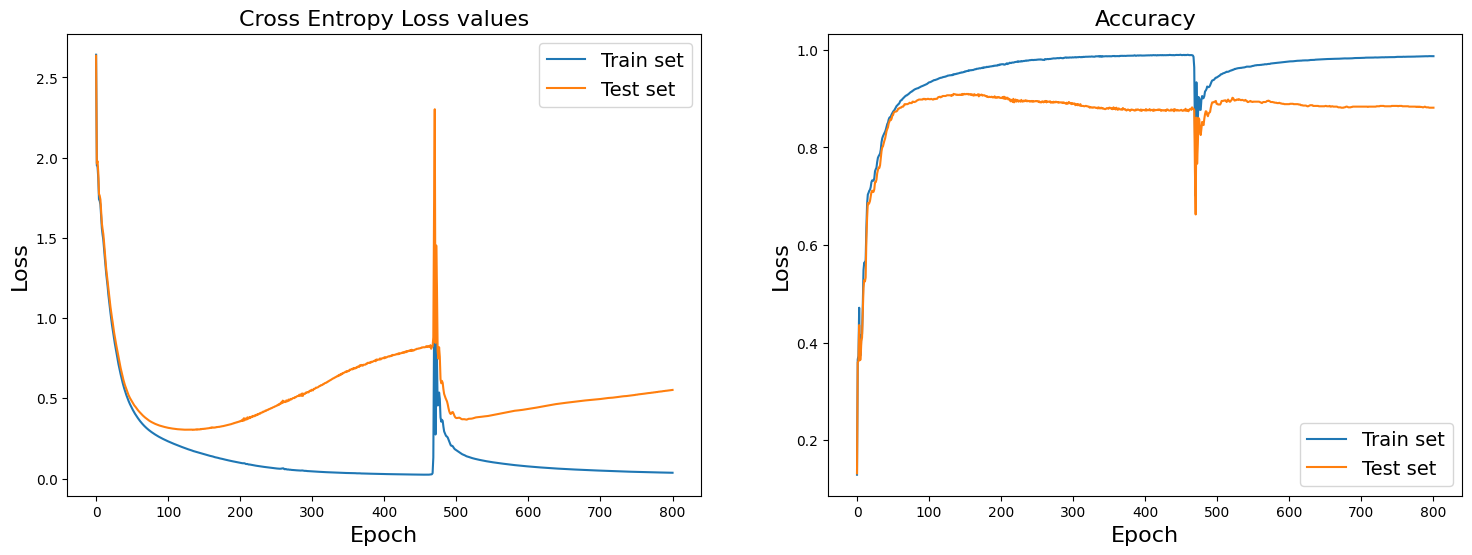

In [21]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

ax0.plot(epochs, gat_train_loss_array, label = "Train set")
ax0.plot(epochs, gat_test_loss_array, label = "Test set")

ax1.plot(epochs, gat_train_acc_array, label="Train set")
ax1.plot(epochs, gat_test_acc_array, label = "Test set")

ax0.set_xlabel("Epoch", size=16)
ax0.set_ylabel("Loss", size=16)

ax1.set_xlabel("Epoch", size=16)
ax1.set_ylabel("Loss", size=16)

ax0.legend(fontsize=14);
ax1.legend(fontsize=14);

ax0.set_title("Cross Entropy Loss values", size=16);
ax1.set_title("Accuracy", size=16);